# Data exploration

### <font color='red'> Import packages</font>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier

### <font color='red'> Read CSV into Pandas Dataframe</font>

In [2]:
data = pd.read_csv('winequality-red.csv')
data.columns = [col.strip() for col in data.columns]

### <font color='red'> Print total rows and columns</font>

In [3]:
# Total rows
print(f"Total number of observations: {data.shape[0]}\n")

# Total columns
print(f"Total number of columns: {data.shape[1]}\n")

Total number of observations: 1599

Total number of columns: 12



### <font color='red'> Print description of each column</font>

In [4]:
pd.set_option('display.max_columns', None)
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### <font color='red'> Print how many data is missing</font>

In [5]:
null_data_count = data.isnull().sum().sum()
print (f"There are total of {null_data_count} missing data")

There are total of 0 missing data


### <font color='red'> Plot data</font>

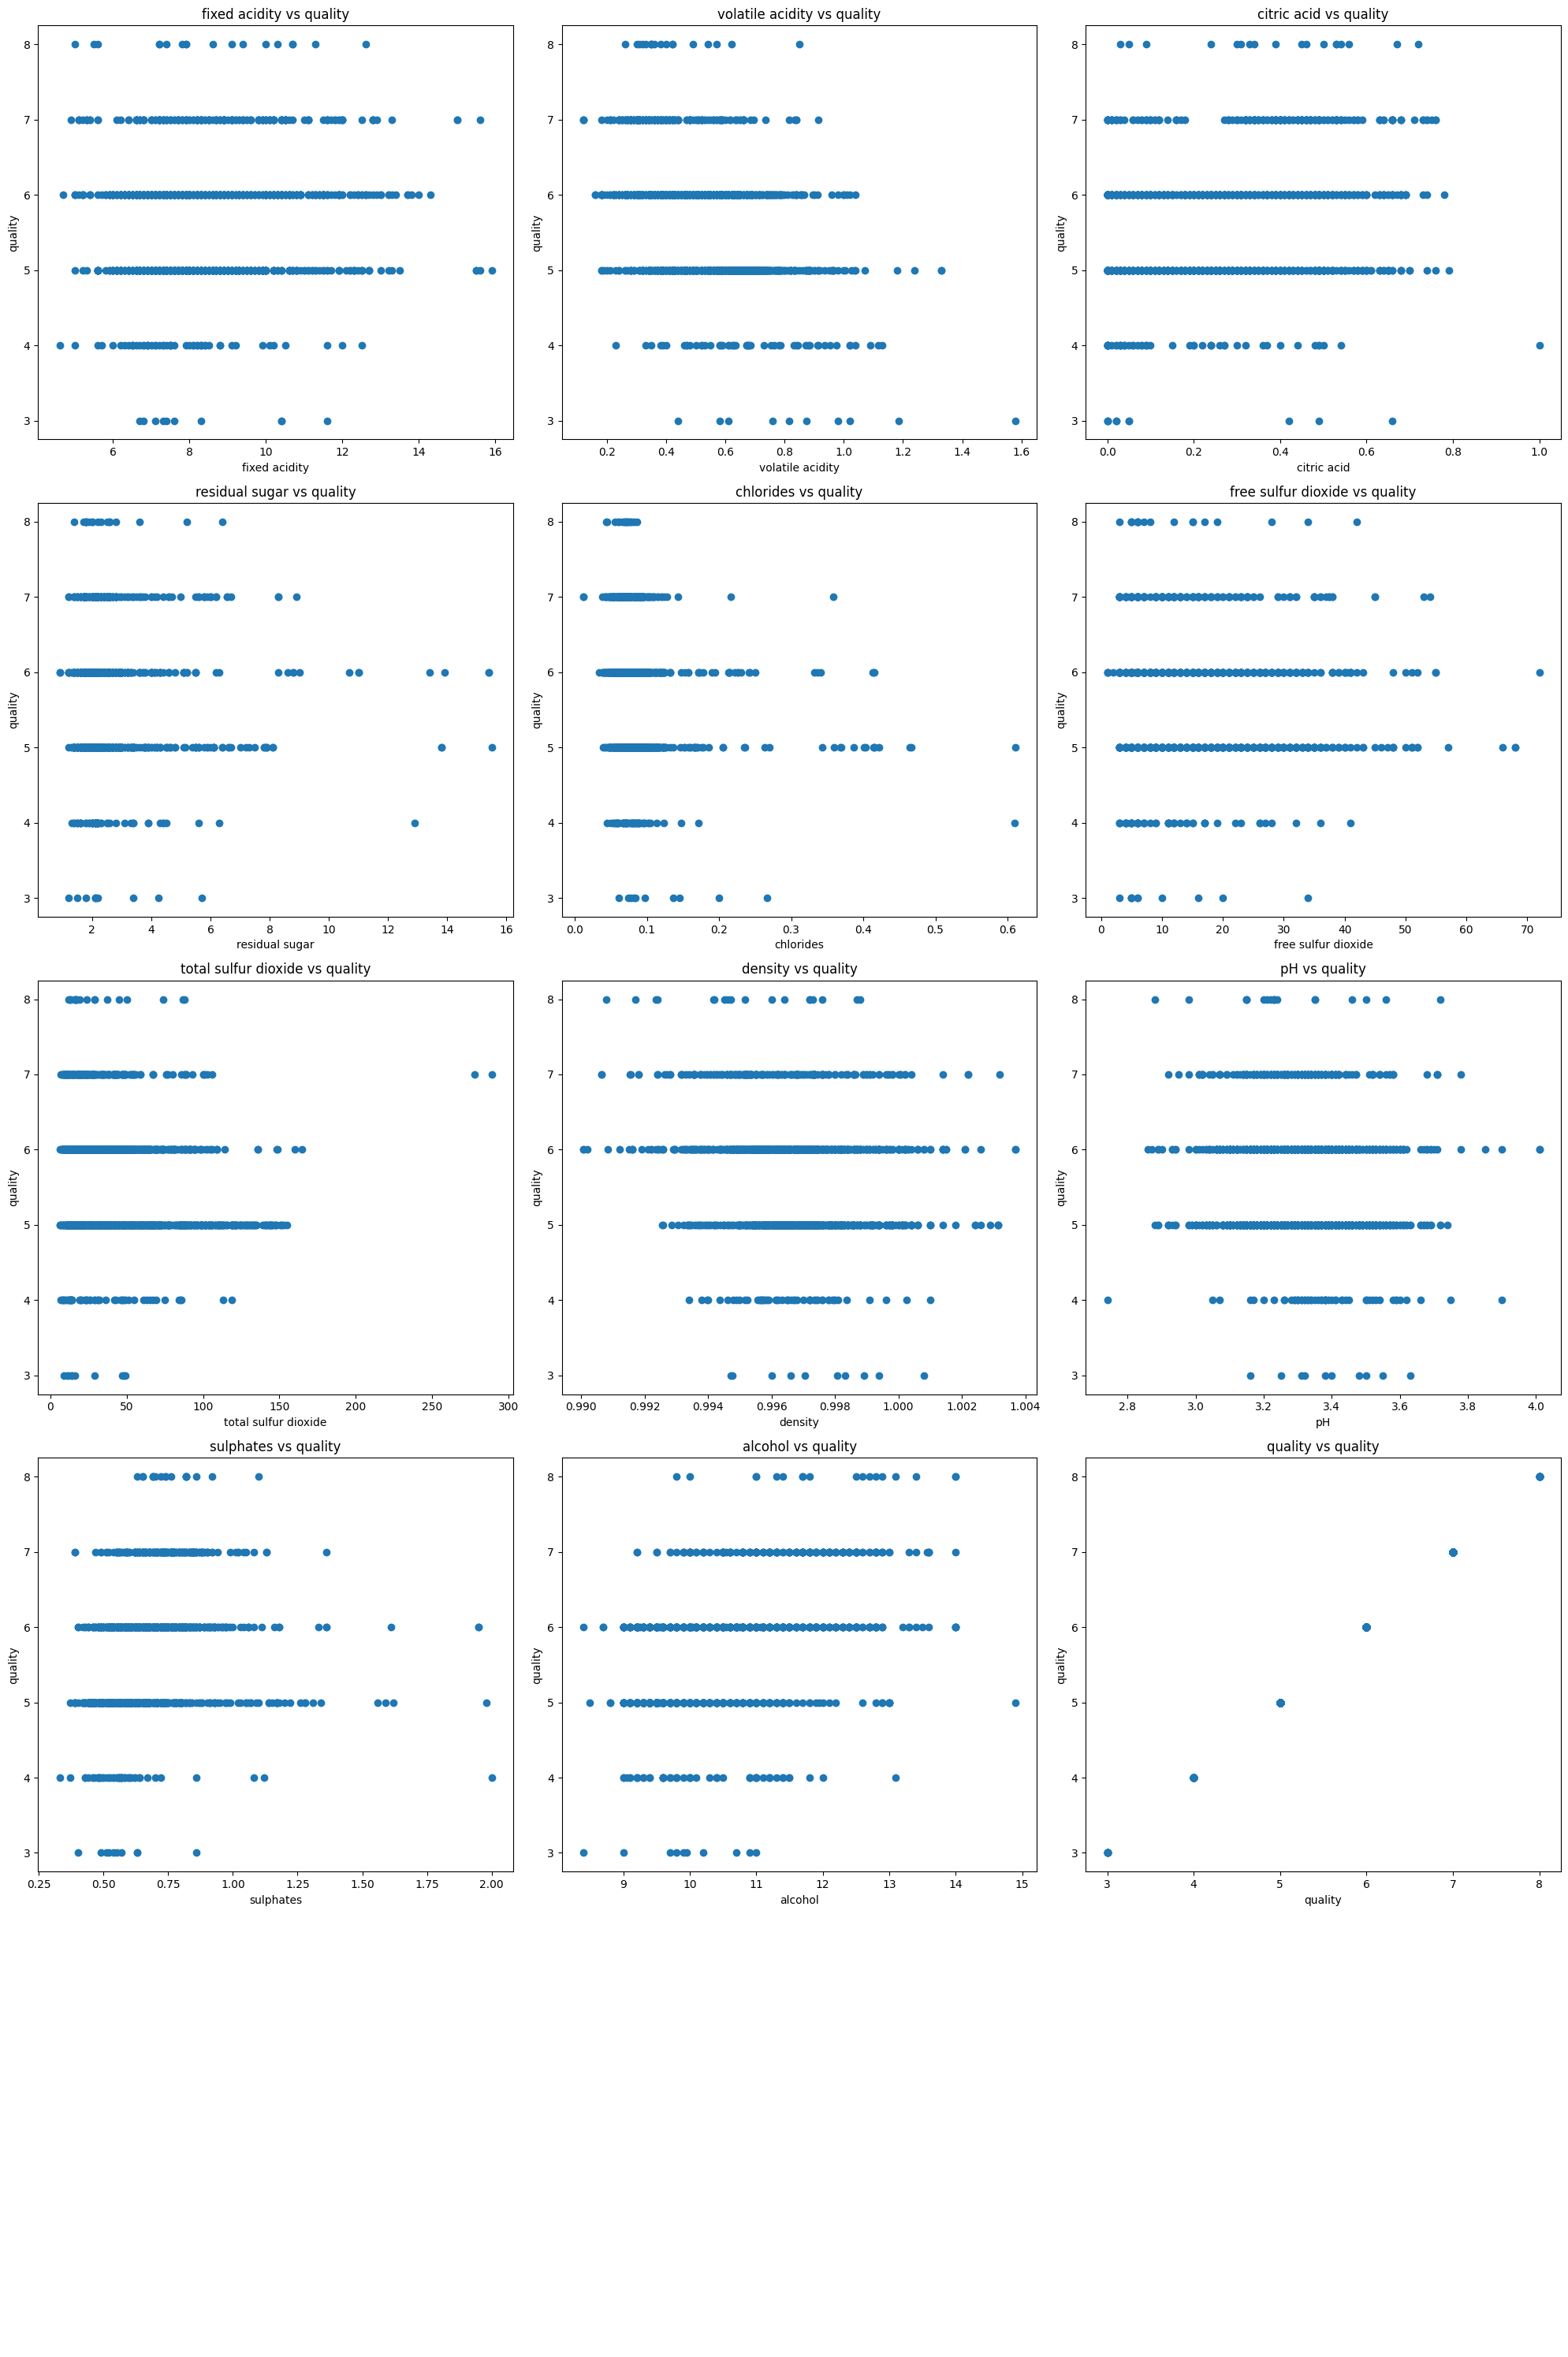

In [6]:
plt_cols = 3
plt_rows = len(data.columns) // plt_cols + 1

fig, axes = plt.subplots(nrows=plt_rows, ncols=plt_cols, figsize=(20, 6*plt_rows))

for i in range(plt_rows * plt_cols):
    # If this subplot index is beyond the number of columns in your data, hide it
    if i >= len(data.columns):
        axes[i // plt_cols, i % plt_cols].axis('off')
    else:
        col = data.columns[i]
        ax = axes[i // plt_cols, i % plt_cols]
        ax.scatter(data[col], data['quality'])
        ax.set_xlabel(col)
        ax.set_ylabel('quality')
        ax.set_title(f'{col} vs quality')

plt.tight_layout()
plt.show()


### <font color='red'> Plot data distribution</font>

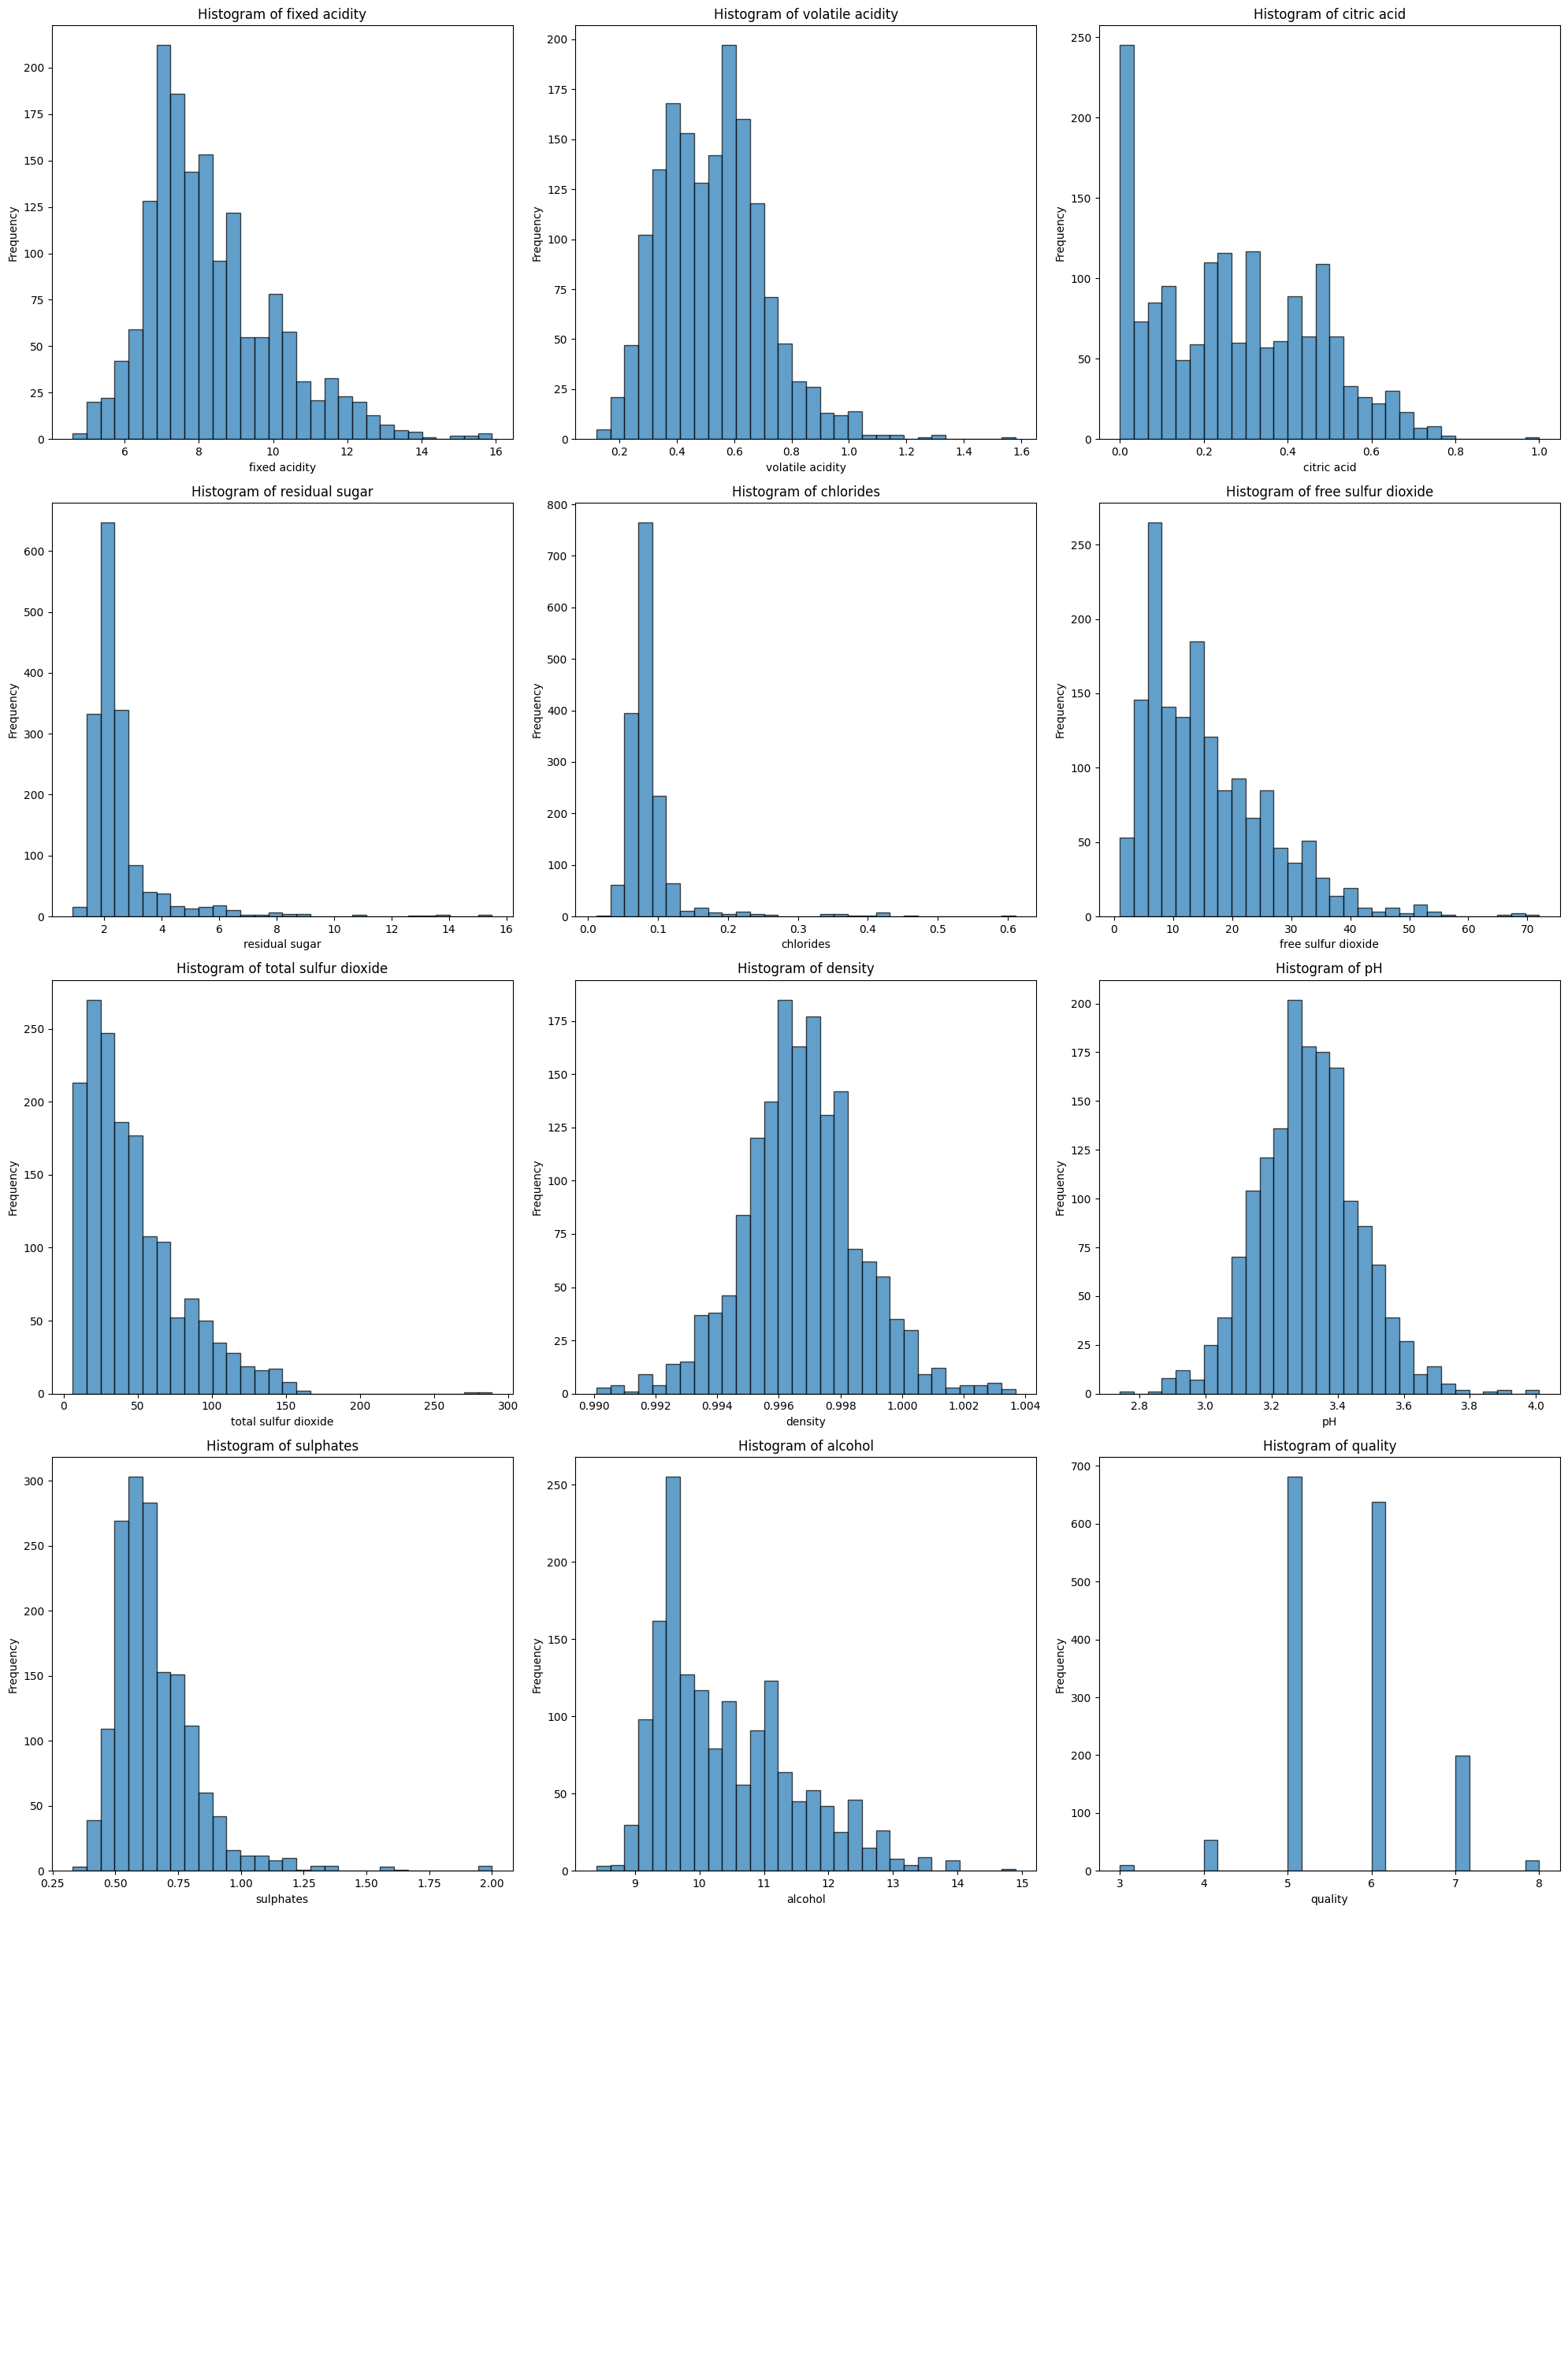

In [7]:
plt_cols = 3
plt_rows = len(data.columns) // plt_cols + 1

fig, axes = plt.subplots(nrows=plt_rows, ncols=plt_cols, figsize=(20, 6*plt_rows))

for i in range(plt_rows * plt_cols):
    # If this subplot index is beyond the number of columns in your data, hide it
    if i >= len(data.columns):
        axes[i // plt_cols, i % plt_cols].axis('off')
    else:
        col = data.columns[i]
        ax = axes[i // plt_cols, i % plt_cols]
        ax.hist(data[col], bins=30, edgecolor='k', alpha=0.7)
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

# Data preprocessing

### <font color='red'> Create isolation forest model to remove outliers</font>

In [8]:
old_data_length = len(data)
IF_model = IsolationForest(contamination=0.1) # Remove 10% data
outliers = IF_model.fit_predict(data) # train IF model
data['outliers'] = outliers

# Remove outliers
data_outliers = data[data['outliers'] == -1]
new_data = data[data['outliers'] != -1].drop(columns = ['outliers'])

new_data_len = len(new_data)

print(f"There are total {old_data_length - new_data_len} rows been removied.")

There are total 160 rows been removied.


### <font color='red'> Create an function to classify wine quality into different categories</font>

Great wine: Quality >= 90%
Good wine: 70% <= Quality < 90%
Normal wine: 30% <= Quality < 70%
Bad wine: Quality < 30%

In [9]:
def wine_classifier(quality, top_percent):
    if quality >= top_percent[0.9]:
        return 'Great'
    elif quality >= top_percent[0.7]:
        return 'Good'
    elif quality >= top_percent[0.3]:
        return 'Normal'
    else:
        return 'Bad'

### <font color='red'> Data classifier </font>

In [10]:
top_percent = new_data['quality'].quantile([0.3, 0.7, 0.9])

quality = []
for index, row in new_data.iterrows():
    quality.append(wine_classifier(row['quality'], top_percent))

new_data['classified_quality'] = quality

### <font color='red'> Split dataset into x and y and one hot encode classified quality column </font>

In [11]:
x = new_data.drop(columns=['quality', 'classified_quality'], axis=1)
y = OneHotEncoder().fit_transform(new_data[['classified_quality']]).toarray()


### <font color='red'> Train test split </font>

In [12]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=10)

### <font color='red'> Normalizing the data </font>

In [13]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
scale_xTrain = minmax_scaler.fit_transform(xTrain)
scale_xTest = minmax_scaler.transform(xTest)

# Model Building

### <font color='red'> Train SVM + Tune Hyperparameters </font>

In [14]:
param_distributions = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto', 0.1, 1],
}

random_search = RandomizedSearchCV(
    SVC(decision_function_shape='ovr'),
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=10
)

random_search.fit(scale_xTrain, yTrain.argmax(axis=1))
best_params = random_search.best_params_

# 3. Train SVM with Best Hyperparameters
svm_model = SVC(**best_params)
svm_model.fit(scale_xTrain, yTrain.argmax(axis=1))

# 4. Evaluate Model
yPred = svm_model.predict(scale_xTest)
accuracy = accuracy_score(yTest.argmax(axis=1), yPred)
classification_rep = classification_report(yTest.argmax(axis=1), yPred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)

Best Hyperparameters: {'kernel': 'rbf', 'gamma': 1, 'degree': 4, 'C': 1000.0}
Accuracy: 0.6493055555555556

Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.25      0.21         8
           1       0.62      0.61      0.61       116
           2       0.71      0.63      0.67        35
           3       0.70      0.71      0.71       129

    accuracy                           0.65       288
   macro avg       0.55      0.55      0.55       288
weighted avg       0.65      0.65      0.65       288



### <font color='red'> Training Inital Neural Network Model </font>

In [15]:
#change y arrays to int arrays
int_yTrain = yTrain.astype(int)
int_yTest = yTest.astype(int)

#create NN with input layer that takes in 11 features. Has 6 hidden layers, 512, 256, 128, 64, 32, and 4 notes respectively. 
#All have 'relu' activation functions except for last layer, which uses 'softmax'
nnmodel = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(11,)),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(4, activation="softmax") 
    ])

#compile model using the adam optimization algo, using categorical crossentropy since we have a multiclass model
nnmodel.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 50
batch = 32
modelfit = nnmodel.fit(scale_xTrain, int_yTrain, epochs=epochs, batch_size=batch)
nnpredict = nnmodel.predict(scale_xTest)

test_loss, test_accuracy = nnmodel.evaluate(scale_xTest, int_yTest)
print(test_accuracy)

Epoch 1/50
36/36 [==============================] - 1s 2ms/step - loss: 1.0643 - accuracy: 0.4909
Epoch 2/50
36/36 [==============================] - 0s 2ms/step - loss: 0.9038 - accuracy: 0.5847
Epoch 3/50
36/36 [==============================] - 0s 2ms/step - loss: 0.8717 - accuracy: 0.6116
Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 0.8544 - accuracy: 0.6308
Epoch 5/50
36/36 [==============================] - 0s 2ms/step - loss: 0.8576 - accuracy: 0.6229
Epoch 6/50
36/36 [==============================] - 0s 2ms/step - loss: 0.8678 - accuracy: 0.6316
Epoch 7/50
36/36 [==============================] - 0s 2ms/step - loss: 0.8367 - accuracy: 0.6394
Epoch 8/50
36/36 [==============================] - 0s 2ms/step - loss: 0.8309 - accuracy: 0.6377
Epoch 9/50
36/36 [==============================] - 0s 2ms/step - loss: 0.8160 - accuracy: 0.6464
Epoch 10/50
36/36 [==============================] - 0s 2ms/step - loss: 0.8262 - accuracy: 0.6394
Epoch 11/50
36/36 [

### <font color='red'> Tuning NNM Hyperparameters </font>

In [16]:
#create wrapper in order to format keras for scikit-learn, trying glorot uniform and drop out layers this time
def create_model(activation='relu', optimizer='adam', kernel_initializer='glorot_uniform', dropout_rate=0.2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(11,)),
        tf.keras.layers.Dense(512, activation=activation, kernel_initializer=kernel_initializer),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(256, activation=activation, kernel_initializer=kernel_initializer),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation=activation, kernel_initializer=kernel_initializer),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation=activation, kernel_initializer=kernel_initializer),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(32, activation=activation, kernel_initializer=kernel_initializer),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(4, activation="softmax") 
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = KerasClassifier(build_fn = create_model, verbose = 0, kernel_initializer = 'glorot_uniform', activation = 'relu',dropout_rate = 0.2)

#testing adam, rmsprop, or sgd for best optimizer, as well as best batch size and number of epochs.
hparam = {'epochs': [36, 50, 100], 
          'batch_size': [32,64],  
          'optimizer': ['adam', 'rmsprop', 'SGD'], 
          'kernel_initializer': ['glorot_uniform', 'normal'],
          'dropout_rate': [0.2,0.3,0.4],
          'activation': ['relu','tanh','sigmoid','softmax']
          }

random_search = RandomizedSearchCV(
    model,
    param_distributions = hparam,
    n_iter = 10,
    n_jobs = -1,
    cv = 5,
    scoring = 'accuracy',
    verbose = 2,
    random_state = 10

)


random_search.fit(scale_xTrain, int_yTrain)
print("Best Hyperparameters:", random_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Tristan H\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best Hyperparameters: {'optimizer': 'SGD', 'kernel_initializer': 'normal', 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 64, 'activation': 'relu'}


### <font color='red'> NNM With Best Parameters </font>

In [17]:
#implementing model with best hyperparameters
activation = 'relu'
kernel_initializer = 'normal'
dropout_rate = .2

tuned_nnmodel = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(11,)),
        tf.keras.layers.Dense(512, activation=activation,kernel_initializer=kernel_initializer),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(256, activation=activation,kernel_initializer=kernel_initializer),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation=activation,kernel_initializer=kernel_initializer),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation=activation,kernel_initializer=kernel_initializer),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(32, activation=activation,kernel_initializer=kernel_initializer),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(4, activation='softmax',kernel_initializer=kernel_initializer) 
    ])

tuned_nnmodel.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 50
batch = 64
tuned_fitmodel = tuned_nnmodel.fit(scale_xTrain, int_yTrain, epochs=epochs, batch_size=batch)

test_loss, test_accuracy = tuned_nnmodel.evaluate(scale_xTest, int_yTest)

tuned_nnpredict = tuned_nnmodel.predict(scale_xTest)
classification_rep = classification_report(int_yTest.argmax(axis=1), tuned_nnpredict.argmax(axis=1))
print("Accuracy:", test_accuracy)


Epoch 1/50
18/18 [==============================] - 1s 3ms/step - loss: 1.3757 - accuracy: 0.4014
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 1.3543 - accuracy: 0.4335
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 1.3348 - accuracy: 0.4335
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: 1.3170 - accuracy: 0.4335
Epoch 5/50
18/18 [==============================] - 0s 3ms/step - loss: 1.3007 - accuracy: 0.4335
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 1.2858 - accuracy: 0.4335
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 1.2722 - accuracy: 0.4335
Epoch 8/50
18/18 [==============================] - 0s 3ms/step - loss: 1.2596 - accuracy: 0.4335
Epoch 9/50
18/18 [==============================] - 0s 3ms/step - loss: 1.2483 - accuracy: 0.4335
Epoch 10/50
18/18 [==============================] - 0s 3ms/step - loss: 1.2376 - accuracy: 0.4335
Epoch 11/50
18/18 [

c:\Users\Tristan H\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tristan H\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tristan H\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf